In [1]:
#with Recurrent dropout and window sliding
import keras
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ELU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, LSTM, RepeatVector, Lambda,Bidirectional,CuDNNLSTM
from keras import regularizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import objectives
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.regularizers import l2
from keras import layers, models

Using TensorFlow backend.


In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
y_train_valid -= 769
y_test = y_test-769

In [5]:
def rnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.25, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.25, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))    
    model.add(Dense(32,activation='elu'))
    model.add(Dropout(0.5))    
    model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.02)))    
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
    return model

In [6]:
# def rnn(input_shape):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(32, recurrent_dropout=0.25, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
#     model.add(BatchNormalization())
#     model.add(Bidirectional(LSTM(16, recurrent_dropout=0.25, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
#     model.add(BatchNormalization())
#     model.add(Flatten())
#     model.add(Dropout(0.5))    
#     model.add(Dense(32,activation='relu'))
#     model.add(Dropout(0.5))    
#     model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.05)))    
#     opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
#     model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
#     return model

In [7]:
def train(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train,y_train,batch_size=50,epochs=200,shuffle=True,validation_split = 0.2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

In [8]:
def predict(model,x_test,y_test):
    y_pred = model.predict(x_test)
    accuracy = 0
    for i in range(y_pred.shape[0]):
        if np.argmax(y_test[i]) == np.argmax(y_pred[i]):
            accuracy += 1
    accuracy /= x_test.shape[0]
    return accuracy

In [9]:
window_length = 10
hop_length = 5
n_windows =(1000-window_length) // hop_length + 1 

In [10]:
def reshape(data): #by default data's dimesnion is 3
    data_new = np.zeros((data.shape[0],n_windows,window_length*22)) #local variable
    for i in range(data.shape[0]):
        raw = data[i].transpose(1,0)
        for j in range(n_windows):
            data_new[i,j] = raw[j*hop_length:j*hop_length+window_length].flatten()
    return data_new


In [11]:
x_train = X_train_valid[:,:22,:].astype('float32')
x_test = X_test[:,:22,:].astype('float32')

y_train = y_train_valid
y_test = y_test

x_train = reshape(x_train)# (2115, 199, 220)
x_test = reshape(x_test)# (443, 199, 220)

Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 26s 15ms/step - loss: 21.1031 - acc: 0.2701 - val_loss: 18.7984 - val_acc: 0.3002
Epoch 2/200
1692/1692 [==============================] - 23s 14ms/step - loss: 18.6251 - acc: 0.3528 - val_loss: 17.1793 - val_acc: 0.3286
Epoch 3/200
1692/1692 [==============================] - 25s 14ms/step - loss: 16.8099 - acc: 0.3871 - val_loss: 15.7171 - val_acc: 0.3570
Epoch 4/200
1692/1692 [==============================] - 23s 14ms/step - loss: 15.2912 - acc: 0.4178 - val_loss: 14.5284 - val_acc: 0.3735
Epoch 5/200
1692/1692 [==============================] - 24s 14ms/step - loss: 14.0504 - acc: 0.4639 - val_loss: 13.5008 - val_acc: 0.3641
Epoch 6/200
1692/1692 [==============================] - 24s 14ms/step - loss: 12.9644 - acc: 0.4787 - val_loss: 12.6089 - val_acc: 0.4066
Epoch 7/200
1692/1692 [==============================] - 28s 16ms/step - loss: 12.0339 - acc: 0.5077 - val_loss: 11.824

Epoch 60/200
1692/1692 [==============================] - 40s 24ms/step - loss: 1.2977 - acc: 0.8712 - val_loss: 2.8987 - val_acc: 0.4492
Epoch 61/200
1692/1692 [==============================] - 39s 23ms/step - loss: 1.2956 - acc: 0.8717 - val_loss: 3.3552 - val_acc: 0.4326
Epoch 62/200
1692/1692 [==============================] - 36s 22ms/step - loss: 1.2815 - acc: 0.8723 - val_loss: 3.1996 - val_acc: 0.4610
Epoch 63/200
1692/1692 [==============================] - 36s 21ms/step - loss: 1.2345 - acc: 0.8794 - val_loss: 3.1320 - val_acc: 0.4610
Epoch 64/200
1692/1692 [==============================] - 36s 21ms/step - loss: 1.2700 - acc: 0.8753 - val_loss: 3.3087 - val_acc: 0.4444
Epoch 65/200
1692/1692 [==============================] - 37s 22ms/step - loss: 1.2457 - acc: 0.8806 - val_loss: 3.5177 - val_acc: 0.3972
Epoch 66/200
1692/1692 [==============================] - 36s 21ms/step - loss: 1.2375 - acc: 0.8706 - val_loss: 3.2275 - val_acc: 0.4421
Epoch 67/200
1692/1692 [==========

1692/1692 [==============================] - 35s 21ms/step - loss: 1.0314 - acc: 0.8818 - val_loss: 3.5102 - val_acc: 0.4043
Epoch 179/200
1692/1692 [==============================] - 35s 21ms/step - loss: 1.0668 - acc: 0.8848 - val_loss: 3.3993 - val_acc: 0.4184
Epoch 180/200
1692/1692 [==============================] - 35s 21ms/step - loss: 1.0115 - acc: 0.8966 - val_loss: 3.3548 - val_acc: 0.4090
Epoch 181/200
1692/1692 [==============================] - 35s 21ms/step - loss: 1.0004 - acc: 0.8954 - val_loss: 3.5862 - val_acc: 0.4113
Epoch 182/200
1692/1692 [==============================] - 33s 20ms/step - loss: 1.0323 - acc: 0.8853 - val_loss: 2.9241 - val_acc: 0.4326
Epoch 183/200
1692/1692 [==============================] - 35s 21ms/step - loss: 0.9912 - acc: 0.9043 - val_loss: 3.1060 - val_acc: 0.4019
Epoch 184/200
1692/1692 [==============================] - 34s 20ms/step - loss: 0.9897 - acc: 0.8913 - val_loss: 3.5386 - val_acc: 0.3972
Epoch 185/200
1692/1692 [================

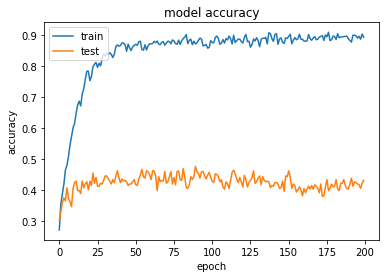

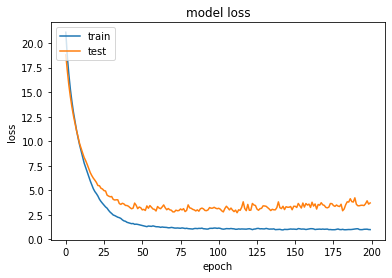

0.43115124153498874
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 199, 256)          357376    
_________________________________________________________________
batch_normalization_1 (Batch (None, 199, 256)          1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 199, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 199, 128)          164352    
_________________________________________________________________
batch_normalization_2 (Batch (None, 199, 128)          512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 25472)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None

In [12]:
def RNN(x_train,y_train,x_test,y_test):
    train_example = x_train
    test_example = x_test
    train_target = keras.utils.to_categorical(y_train, 4)
    test_target = keras.utils.to_categorical(y_test, 4)
    
    model = rnn(train_example[0].shape)
    model = train(model,train_example,train_target,test_example,test_target)
    acc = predict(model,test_example,test_target)
    print(acc)
    model.summary()
    return acc

acc = RNN(x_train,y_train,x_test,y_test)